In [5]:
import itertools
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import ijson
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from shapely.geometry import shape, Point
import shapely

# Assigning tweets to an SA2

## Loading SA2 data

In [6]:
sa2_data = "../data/1270055001_sa2_2016_aust_shape.zip"

sa2_df = gpd.read_file(sa2_data)
# filter to only include melbourne
sa2_df = sa2_df[sa2_df['GCC_NAME16'] == 'Greater Melbourne']
sa2_df

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
682,206011105,21105,Brunswick,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,5.1425,"POLYGON ((144.94974 -37.76277, 144.95003 -37.7..."
683,206011106,21106,Brunswick East,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,2.1680,"POLYGON ((144.97340 -37.76204, 144.97335 -37.7..."
684,206011107,21107,Brunswick West,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,3.1795,"POLYGON ((144.93407 -37.75969, 144.93405 -37.7..."
685,206011108,21108,Coburg,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,6.9346,"POLYGON ((144.94847 -37.73951, 144.94878 -37.7..."
686,206011109,21109,Pascoe Vale South,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,2.9887,"POLYGON ((144.93264 -37.74226, 144.93251 -37.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,214021381,21381,Mount Eliza,21402,Mornington Peninsula,214,Mornington Peninsula,2GMEL,Greater Melbourne,2,Victoria,23.2077,"POLYGON ((145.07201 -38.18710, 145.07216 -38.1..."
987,214021382,21382,Mount Martha,21402,Mornington Peninsula,214,Mornington Peninsula,2GMEL,Greater Melbourne,2,Victoria,30.2094,"POLYGON ((145.02584 -38.25242, 145.02616 -38.2..."
988,214021383,21383,Point Nepean,21402,Mornington Peninsula,214,Mornington Peninsula,2GMEL,Greater Melbourne,2,Victoria,67.1875,"MULTIPOLYGON (((144.73141 -38.35025, 144.73147..."
989,214021384,21384,Rosebud - McCrae,21402,Mornington Peninsula,214,Mornington Peninsula,2GMEL,Greater Melbourne,2,Victoria,23.7957,"POLYGON ((144.87372 -38.36268, 144.87388 -38.3..."


## Greater Melbourne bounding box

In [7]:
greater_melb = sa2_df.dissolve(by='STE_NAME16')['geometry'].iloc[0]

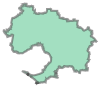

In [8]:
greater_melb

In [9]:
greater_melb.bounds

(144.33363404800002, -38.50298801599996, 145.8784120140001, -37.17509899299995)

## Determining tweet location

In [10]:

sa2_main16_df = sa2_df[['SA2_MAIN16', 'geometry']]


# return the SA2 main code for 2016 boundaries
def get_sa2_main16(coordinates):
    if coordinates is None:
        return pd.NA
    
    point = Point([coordinates['longitude'], coordinates['latitude']])
    # check if point falls in cell
    row_filter = sa2_main16_df.apply(lambda row: row['geometry'].contains(point) or row['geometry'].intersects(point), axis=1)
    filtered_rows = sa2_main16_df[row_filter]
    if (filtered_rows.size == 0):
        return pd.NA

    return filtered_rows['SA2_MAIN16'].iloc[0]


In [11]:
test_point = sa2_main16_df['geometry'].iloc[0].representative_point()
lon, lat = test_point.coords[0]

In [12]:
get_sa2_main16({"latitude": lat, "longitude":lon})

'206011105'

In [13]:
# Test the correct code produced for a representative point in each region
index = 50
test_point = sa2_main16_df['geometry'].iloc[index].representative_point()
lon, lat = test_point.coords[0]
out_sa2_main16 = get_sa2_main16({"latitude": lat, "longitude":lon})
print(f"Output: {out_sa2_main16}")
print(f"Expected: {sa2_main16_df['SA2_MAIN16'].iloc[index]}")

Output: 207011155
Expected: 207011155


# Language Spoken at home 

In [14]:
language_sa2_data = '..\data\SA2-P13_Language_Spoken_at_Home_by_Sex-Census_2016.json\sa2_p13_lang_spoken_at_home_by_sex_census_2016-6394559813018131150.json'
#language_sa2_df = pd.read_json(language_sa2_data, index='features')
lang_dicts = []
with open(language_sa2_data) as f:
    data_points = ijson.items(f, 'features.item.properties')
    lang_dicts = list(data_points)

lang_df = pd.DataFrame(lang_dicts)
lang_df
        

,sa2_name16,sa2_main16,tot_p,lang_spoken_home_ns_p,spks_eng_on_p
0,Collingwood,206071141,8619,1073,5112
1,Prahran - Windsor,206061136,19768,1864,13354
2,Hadfield,210031440,5613,291,2741
3,Sunbury - South,210041241,26335,1224,22708
4,Sunbury,210041240,12576,539,10933
...,...,...,...,...,...
304,Flinders,214021378,5269,357,4697
305,Hastings - Somers,214021379,21797,1270,19743
306,Mornington,214021380,23344,1066,20838
307,Mount Eliza,214021381,17475,568,15546


- determine statistics
- lang_spoken_home_ns_p: this gives people who didn't report if they speak another language at home. 
- let's assume that the number of people who do so are randomly distributed
- then the people who reported speaking a language is num_reported = tot_p - lang_spoken_home_ns_p
- the proportion of people who speak a language other than English is then 1-spks_eng_on_p/(num_reported)


In [15]:
lang_df['num_reported'] = lang_df['tot_p'] - lang_df['lang_spoken_home_ns_p']
lang_df['prop_spk_english_only'] = lang_df['spks_eng_on_p']/lang_df['num_reported']
lang_df['prop_spk_other_lang'] = 1 - lang_df['prop_spk_english_only']

Let's look at the areas with the lowest proportion of people who speak English only:

In [16]:
lang_df.sort_values(by='prop_spk_other_lang').head(10)

,sa2_name16,sa2_main16,tot_p,lang_spoken_home_ns_p,spks_eng_on_p,num_reported,prop_spk_english_only,prop_spk_other_lang
219,Bunyip - Garfield,212011288,8467,526,7679,7941,0.967007,0.032993
305,Hastings - Somers,214021379,21797,1270,19743,20527,0.961806,0.038194
117,Panton Hill - St Andrews,209031212,5003,369,4452,4634,0.960725,0.039275
153,Riddells Creek,210021234,3882,121,3609,3761,0.959585,0.040415
122,Hurstbridge,209031210,3377,106,3134,3271,0.958117,0.041883
308,Somerville,214021385,17709,852,16150,16857,0.958059,0.041941
217,Yarra Valley,211051286,15901,955,14317,14946,0.957915,0.042085
304,Flinders,214021378,5269,357,4697,4912,0.956230,0.043770
203,Healesville - Yarra Glen,211051276,13661,812,12260,12849,0.954160,0.045840
154,Romsey,210021235,9197,642,8160,8555,0.953828,0.046172


This seems reasonable. Now let's look at the areas with the highest proportion of people who do not only speak English

In [17]:
lang_df.sort_values(by='prop_spk_other_lang').dropna().tail(10)

,sa2_name16,sa2_main16,tot_p,lang_spoken_home_ns_p,spks_eng_on_p,num_reported,prop_spk_english_only,prop_spk_other_lang
233,Dandenong,212041311,31369,2840,7677,28529,0.269095,0.730905
251,Cairnlea,213011329,9732,377,2517,9355,0.269054,0.730946
232,Clayton South,212041310,12857,601,3276,12256,0.267298,0.732702
53,Melbourne,206041122,57734,10183,12602,47551,0.265021,0.734979
166,Campbellfield - Coolaroo,210051243,16201,1221,3863,14980,0.257877,0.742123
162,Meadow Heights,210051247,14839,938,3492,13901,0.251205,0.748795
240,Springvale South,212041318,12690,524,2885,12166,0.237136,0.762864
264,Sunshine North,213011337,11739,597,2616,11142,0.234787,0.765213
262,St Albans - South,213011335,17796,1491,3427,16305,0.210181,0.789819
239,Springvale,212041317,21958,1238,3809,20720,0.183832,0.816168


This also seems reasonable

array([[<AxesSubplot:title={'center':'prop_spk_other_lang'}>]],
      dtype=object)

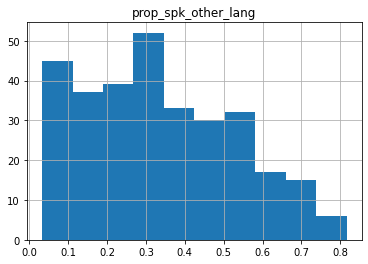

In [18]:
lang_df.hist('prop_spk_other_lang')

In [19]:
lang_df[['sa2_main16', 'sa2_name16', 'tot_p', 'prop_spk_other_lang']].set_index('sa2_main16').to_json('../data/sa2_language_spoken_at_home_proportion_census_2016.json', orient='index')

# SEIFA



In [20]:
seifa_sa2_data = '..\data\ABS_-_Socio-Economic_Indexes_for_Areas__SEIFA__-_The_Index_of_Relative_Socio-economic_Advantage_and_Disadvantage__SA2__2016.json\sa2_seifa_irsad_2016-8012956430373350930.json'
#seifa_sa2_df = pd.read_json(seifa_sa2_data, index='features')
seifa_dicts = []
with open(seifa_sa2_data) as f:
    data_points = ijson.items(f, 'features.item.properties')
    seifa_dicts = list(data_points)

seifa_df = pd.DataFrame(seifa_dicts)

In [21]:
seifa_df.sort_values(by='state_rank', ascending=False)

,usual_res_pop,state_rank,ur_pop_wthout_sa1_level_score_pc,state,state_percentile,state_decile,max_sa1_score_in_area,sa2_name16,national_percentile,irsad_score,national_decile,national_rank,sa2_main16,min_sa1_score_in_area
20,4962,454,0.10,VIC,100,10,1199,East Melbourne,99,1160,10,2151,206041119,1081
65,16326,453,0.00,VIC,100,10,1201,Glen Iris - East,99,1154,10,2142,207011150,1105
69,16319,452,0.00,VIC,100,10,1180,Surrey Hills (West) - Canterbury,98,1147,10,2127,207011155,1106
54,13050,451,0.00,VIC,100,10,1196,Toorak,97,1144,10,2119,206061138,1098
85,22695,450,0.00,VIC,99,10,1189,Brighton (Vic.),97,1144,10,2118,208011169,937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,14842,7,0.00,VIC,2,1,905,Meadow Heights,4,846,1,71,210051247,734
215,11306,6,0.03,VIC,2,1,915,Doveton,3,844,1,64,212021295,775
27,58,5,0.00,VIC,2,1,838,Braeside,3,838,1,58,208031184,838
155,16122,3,0.16,VIC,1,1,887,Campbellfield - Coolaroo,3,828,1,49,210051243,754


In [22]:
seifa_df['irsad_score'].dtype

dtype('int64')

# Perform tweet analysis

- load filtered tweets
- determine tweet SA2 code
- perform sentiment analysis
- join with language and seifa 
- draw some plots

## Load filtered tweets

In [23]:
tweets_filtered = "../data/twitter-melb-filtered.json"

tweet_df = pd.read_json(tweets_filtered)

In [24]:
tweet_df

,id,key,value,doc
0,494058218352439296,"[melbourne, 2014, 7, 29]",1,"{'_id': '494058218352439296', '_rev': '1-a36dd..."
1,494080521245179904,"[melbourne, 2014, 7, 29]",1,"{'_id': '494080521245179904', '_rev': '1-1f815..."
2,494083269596422144,"[melbourne, 2014, 7, 29]",1,"{'_id': '494083269596422146', '_rev': '1-bf4ef..."
3,494119498538967040,"[melbourne, 2014, 7, 29]",1,"{'_id': '494119498538967042', '_rev': '1-396e5..."
4,494254629937364992,"[melbourne, 2014, 7, 29]",1,"{'_id': '494254629937364994', '_rev': '1-a8297..."
...,...,...,...,...
26894,880342224810123264,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342224810123265', '_rev': '1-bc878..."
26895,880342310948556800,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342310948556800', '_rev': '1-761dd..."
26896,880342654910832640,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342654910832641', '_rev': '1-2c3b1..."
26897,880342724381032448,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342724381032449', '_rev': '1-4ae62..."


In [25]:
# pd.concat([tweet_df, tweet_df['doc'].apply(pd.Series)])

## Determine SA2

In [26]:
def get_tweet_coordinates(tweet_doc):
    """
    Given a tweet doc extract the tweet coordinates
    :param tweet: tweet in JSON format
    :return: dictionary of latitude, longitude
    """
    hasCoordinates = tweet_doc['coordinates']
    if hasCoordinates:
        return {"longitude": hasCoordinates['coordinates'][0], "latitude": hasCoordinates['coordinates'][1]}


In [27]:
tweet_df['coordinates'] = tweet_df['doc'].apply(get_tweet_coordinates)
tweet_df['coordinates'] 

0        {'longitude': 144.9537989, 'latitude': -37.774...
1        {'longitude': 144.91145972, 'latitude': -37.75...
2        {'longitude': 144.91163472, 'latitude': -37.75...
3        {'longitude': 145.01015666, 'latitude': -37.87...
4        {'longitude': 145.266234, 'latitude': -37.8389...
                               ...                        
26894                                                 None
26895                                                 None
26896                                                 None
26897                                                 None
26898                                                 None
Name: coordinates, Length: 26899, dtype: object

In [28]:
tweet_df['coordinates'].dropna().size

1654

In [29]:
tweet_df['sa2'] = tweet_df['coordinates'].apply(get_sa2_main16)

In [30]:
tweet_df['sa2'].head()

0    206011105
1    206031114
2    206031114
3    208021177
4    211011251
Name: sa2, dtype: object

## Perform sentiment analysis

In [31]:
analyser = SentimentIntensityAnalyzer()

sentiments = tweet_df['doc'].apply(lambda d: analyser.polarity_scores(d['text'])).apply(pd.Series)
sentiments.head()
#tweet_df.head()

,neg,neu,pos,compound
0,0.229,0.771,0.000,-0.5362
1,0.000,0.873,0.127,0.4404
2,0.000,0.854,0.146,0.4404
3,0.000,1.000,0.000,0.0000
4,0.336,0.664,0.000,-0.7964


In [32]:
tweet_df = pd.concat([tweet_df, sentiments], axis=1)
tweet_df.head()

,id,key,value,doc,coordinates,sa2,neg,neu,pos,compound
0,494058218352439296,"[melbourne, 2014, 7, 29]",1,"{'_id': '494058218352439296', '_rev': '1-a36dd...","{'longitude': 144.9537989, 'latitude': -37.774...",206011105,0.229,0.771,0.000,-0.5362
1,494080521245179904,"[melbourne, 2014, 7, 29]",1,"{'_id': '494080521245179904', '_rev': '1-1f815...","{'longitude': 144.91145972, 'latitude': -37.75...",206031114,0.000,0.873,0.127,0.4404
2,494083269596422144,"[melbourne, 2014, 7, 29]",1,"{'_id': '494083269596422146', '_rev': '1-bf4ef...","{'longitude': 144.91163472, 'latitude': -37.75...",206031114,0.000,0.854,0.146,0.4404
3,494119498538967040,"[melbourne, 2014, 7, 29]",1,"{'_id': '494119498538967042', '_rev': '1-396e5...","{'longitude': 145.01015666, 'latitude': -37.87...",208021177,0.000,1.000,0.000,0.0000
4,494254629937364992,"[melbourne, 2014, 7, 29]",1,"{'_id': '494254629937364994', '_rev': '1-a8297...","{'longitude': 145.266234, 'latitude': -37.8389...",211011251,0.336,0.664,0.000,-0.7964


## Join with SEIFA

In [33]:
seifa_df.head()

,usual_res_pop,state_rank,ur_pop_wthout_sa1_level_score_pc,state,state_percentile,state_decile,max_sa1_score_in_area,sa2_name16,national_percentile,irsad_score,national_decile,national_rank,sa2_main16,min_sa1_score_in_area
0,19160,142,0.05,VIC,32,4,1040,Altona Meadows,37,966,4,799,213021342,875
1,15053,164,0.13,VIC,37,4,1075,Cranbourne West,41,976,5,891,212031304,889
2,19714,415,0.00,VIC,92,10,1162,Prahran - Windsor,90,1106,9,1965,206061136,841
3,8513,215,0.00,VIC,48,5,1181,Collingwood,51,999,6,1114,206071141,516
4,5604,95,0.07,VIC,21,3,996,Hadfield,28,947,3,604,210031440,850


In [34]:
# reindex SEIFA dataframe to facilitate join
seifa_df = seifa_df.set_index('sa2_main16')

In [35]:
tweet_df = tweet_df.join(seifa_df, on='sa2')

## Join with language

In [36]:
# reindex language dataframe to use sa2 as index
lang_df = lang_df.set_index('sa2_main16')

In [37]:

tweet_df = tweet_df.join(lang_df, on='sa2', lsuffix='lang_')

## Compound sentiment vs seifa

Text(0, 0.5, 'Compound Sentiment')

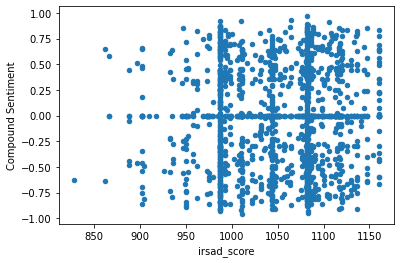

In [38]:
# seifa and sentiment
tweet_df.plot.scatter(x='irsad_score', y='compound')
plt.ylabel('Compound Sentiment')
#tweet_df['irsad_score']

In [39]:
sa2_grouped_tweets = tweet_df.dropna(subset=['sa2']).groupby('sa2', as_index=True)
y = sa2_grouped_tweets['compound'].mean()
x = sa2_grouped_tweets['irsad_score'].first()

irsad_sa2 = pd.concat([x,y], axis=1).dropna()

m: 0.0005049077505473474, b: -0.538236478400628


Text(0, 0.5, 'Mean sentiment (compound)')

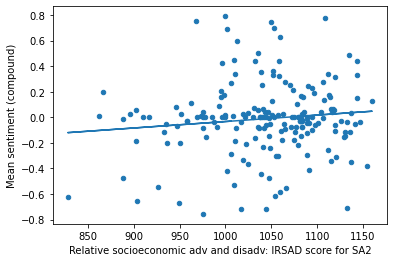

In [40]:
m, b = np.polyfit(irsad_sa2['irsad_score'], irsad_sa2['compound'], 1)
print(f"m: {m}, b: {b}")
irsad_sa2['fit'] = m*irsad_sa2['irsad_score'] + b
irsad_sa2.plot('irsad_score', 'compound', kind='scatter')
plt.plot(irsad_sa2['irsad_score'], irsad_sa2['fit'])
plt.xlabel("Relative socioeconomic adv and disadv: IRSAD score for SA2")
plt.ylabel("Mean sentiment (compound)")

array([[<AxesSubplot:title={'center':'compound'}>]], dtype=object)

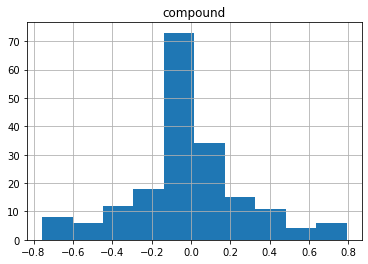

In [41]:
irsad_sa2.hist('compound')

## Count of tweets per SA2 vs SEIFA

In [42]:
sa2_grouped_tweets = tweet_df.dropna(subset=['sa2']).groupby('sa2', as_index=True)
y = sa2_grouped_tweets['id'].count().rename('count')
x = sa2_grouped_tweets['irsad_score'].first()

irsad_sa2 = pd.concat([x,y], axis=1).dropna().sort_values(by='irsad_score')

m: 0.010241349185923291, b: -1.8961981405547852


Text(0, 0.5, 'Count')

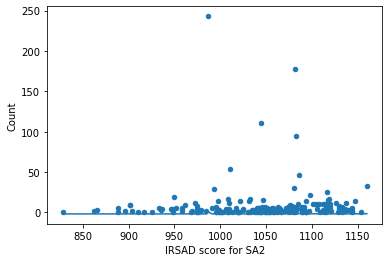

In [43]:
m, b = np.polyfit(irsad_sa2['irsad_score'], irsad_sa2['count'], 1)
print(f"m: {m}, b: {b}")
irsad_sa2['fit'] = m*irsad_sa2['count'] + b
irsad_sa2.plot('irsad_score', 'count', kind='scatter')
plt.plot(irsad_sa2['irsad_score'], irsad_sa2['fit'])
plt.xlabel("IRSAD score for SA2")
plt.ylabel("Count")

## Compound Sentiment vs Diversity Proxy

In [44]:
# scenario specific tweet filter:
keywords = ['scott morrison', 'scomo', 'scummo', 'scumo', 'scotty from marketing']
hashtags = ['auspol', 'ausvotes', 'scottyfrommarketing' \
            'scottyfromphotoops', 'scottythegaslighter','scottythepathologicalliar']
usernames = ['scottmorrisonmp']
hashtags = ['#' + ht for ht in hashtags]
usernames = ['@' + un for un in usernames]
print(hashtags)
print(usernames)
search_words = keywords + hashtags + usernames

def filter_tweet(text, search_words):
    text = text.lower()
    for search_word in search_words:
        if search_word in text:
            #print(f"{search_word} in {text}")
            return True

    return False

['#auspol', '#ausvotes', '#scottyfrommarketingscottyfromphotoops', '#scottythegaslighter', '#scottythepathologicalliar']
['@scottmorrisonmp']


In [45]:
search_words

['scott morrison',
 'scomo',
 'scummo',
 'scumo',
 'scotty from marketing',
 '#auspol',
 '#ausvotes',
 '#scottyfrommarketingscottyfromphotoops',
 '#scottythegaslighter',
 '#scottythepathologicalliar',
 '@scottmorrisonmp']

In [46]:
row_filter = tweet_df['doc'].apply(lambda x: filter_tweet(x['text'], search_words))
diversity_df = tweet_df[row_filter]

In [47]:
diversity_df

,id,key,value,doc,coordinates,sa2,neg,neu,pos,compound,...,national_decile,national_rank,min_sa1_score_in_area,sa2_name16,tot_p,lang_spoken_home_ns_p,spks_eng_on_p,num_reported,prop_spk_english_only,prop_spk_other_lang
0,494058218352439296,"[melbourne, 2014, 7, 29]",1,"{'_id': '494058218352439296', '_rev': '1-a36dd...","{'longitude': 144.9537989, 'latitude': -37.774...",206011105,0.229,0.771,0.000,-0.5362,...,9.0,1812.0,949.0,Brunswick,25424.0,1490.0,16559.0,23934.0,0.691861,0.308139
1,494080521245179904,"[melbourne, 2014, 7, 29]",1,"{'_id': '494080521245179904', '_rev': '1-1f815...","{'longitude': 144.91145972, 'latitude': -37.75...",206031114,0.000,0.873,0.127,0.4404,...,9.0,1843.0,1031.0,Essendon - Aberfeldie,27409.0,1476.0,19107.0,25933.0,0.736783,0.263217
2,494083269596422144,"[melbourne, 2014, 7, 29]",1,"{'_id': '494083269596422146', '_rev': '1-bf4ef...","{'longitude': 144.91163472, 'latitude': -37.75...",206031114,0.000,0.854,0.146,0.4404,...,9.0,1843.0,1031.0,Essendon - Aberfeldie,27409.0,1476.0,19107.0,25933.0,0.736783,0.263217
3,494119498538967040,"[melbourne, 2014, 7, 29]",1,"{'_id': '494119498538967042', '_rev': '1-396e5...","{'longitude': 145.01015666, 'latitude': -37.87...",208021177,0.000,1.000,0.000,0.0000,...,10.0,2001.0,1042.0,Caulfield - North,20963.0,1125.0,14001.0,19838.0,0.705767,0.294233
4,494254629937364992,"[melbourne, 2014, 7, 29]",1,"{'_id': '494254629937364994', '_rev': '1-a8297...","{'longitude': 145.266234, 'latitude': -37.8389...",211011251,0.336,0.664,0.000,-0.7964,...,5.0,994.0,914.0,Bayswater,12054.0,599.0,8060.0,11455.0,0.703623,0.296377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26894,880342224810123264,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342224810123265', '_rev': '1-bc878...",None,<NA>,0.000,0.708,0.292,0.7351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26895,880342310948556800,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342310948556800', '_rev': '1-761dd...",None,<NA>,0.130,0.870,0.000,-0.2732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26896,880342654910832640,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342654910832641', '_rev': '1-2c3b1...",None,<NA>,0.000,0.708,0.292,0.7351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26897,880342724381032448,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342724381032449', '_rev': '1-4ae62...",None,<NA>,0.000,0.924,0.076,0.2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
sa2_grouped_tweets = diversity_df.dropna(subset=['sa2']).groupby('sa2', as_index=True)
y = sa2_grouped_tweets['compound'].mean()
x = sa2_grouped_tweets['prop_spk_other_lang'].first()

irsad_sa2 = pd.concat([x,y], axis=1).dropna().sort_values(by='prop_spk_other_lang')

m: -0.3930270182736668, b: 0.10042606775961788


Text(0, 0.5, 'Compound Sentiment')

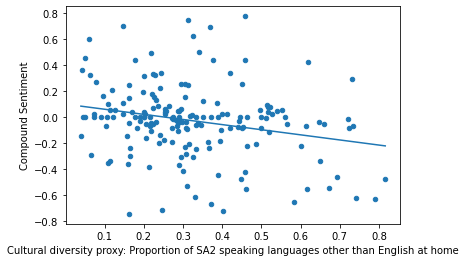

In [49]:
m, b = np.polyfit(irsad_sa2['prop_spk_other_lang'], irsad_sa2['compound'], 1)
print(f"m: {m}, b: {b}")
irsad_sa2['fit'] = m*irsad_sa2['prop_spk_other_lang'] + b
irsad_sa2.plot('prop_spk_other_lang', 'compound', kind='scatter')
plt.plot(irsad_sa2['prop_spk_other_lang'], irsad_sa2['fit'])
plt.xlabel("Cultural diversity proxy: Proportion of SA2 speaking languages other than English at home")
plt.ylabel("Compound Sentiment")

In [50]:
irsad_sa2.head()

,prop_spk_other_lang,compound,fit
sa2,,,
209031212,0.039275,-0.143933,0.084990
209031210,0.041883,0.361200,0.083965
211051276,0.045840,0.000000,0.082410
212011289,0.049001,0.000000,0.081167
209031211,0.050596,0.451500,0.080540


Export diversity/sentiment data

In [51]:
d = {}
d['prop_spk_other_lang'] = list(irsad_sa2['prop_spk_other_lang'].values)
d['compound'] = list(irsad_sa2['compound'].values)
d['fit'] = list(irsad_sa2['fit'].values)
with open('../data/sa2-diversity-sentiment-fit.json', 'w') as f:
    json.dump(d, f)

# Export geojson to use in a map

## Twitter data + sentiment score

In [52]:
tweet_df['text'] = tweet_df['doc'].apply(lambda x: x['text'])
#tweet_df.to_file("data/twitter-melb-filtered.geojson", driver="GeoJSON")

In [53]:
reduced_tweet_df = tweet_df[['id', 'coordinates', 'sa2', 'compound', 'text']].dropna()
reduced_tweet_df = pd.concat([reduced_tweet_df, reduced_tweet_df['coordinates'].apply(pd.Series)], axis=1)
reduced_tweet_df = reduced_tweet_df.drop('coordinates', axis=1).set_index('id')
reduced_tweet_df.head()

,sa2,compound,text,longitude,latitude
id,,,,,
494058218352439296,206011105,-0.5362,"#auspol tweets, an egghead with my twitter nam...",144.953799,-37.774031
494080521245179904,206031114,0.4404,Good on you @glennmcgrath11 &amp; @BrettLee_58...,144.911460,-37.755554
494083269596422144,206031114,0.4404,When @ScottMorrisonMP tries to refoul #highcou...,144.911635,-37.755562
494119498538967040,208021177,0.0000,@elronxenu Then what is the objective of reduc...,145.010157,-37.872971
494254629937364992,211011251,-0.7964,@TonyAbbottMHR How many #smallbusinesses will ...,145.266234,-37.838969


In [54]:
reduced_tweet_gdf = gpd.GeoDataFrame(reduced_tweet_df, geometry=gpd.points_from_xy(reduced_tweet_df.longitude, reduced_tweet_df.latitude))
reduced_tweet_gdf.drop(['latitude', 'longitude'], axis=1)
reduced_tweet_gdf.to_file("../data/twitter-melb-filtered.geojson", driver="GeoJSON")

## Greater Melbourne SA2 GeoJSON + seifa + diversity proxy

In [55]:
seifa_lang_df = pd.concat([seifa_df['irsad_score'], lang_df['prop_spk_other_lang']], axis=1)

In [56]:
lang_df.columns

Index(['sa2_name16', 'tot_p', 'lang_spoken_home_ns_p', 'spks_eng_on_p',
       'num_reported', 'prop_spk_english_only', 'prop_spk_other_lang'],
      dtype='object')

In [57]:
sa2_reduced = sa2_df.set_index('SA2_MAIN16')[['SA2_NAME16', 'geometry']]

In [58]:
sa2_reduced = sa2_reduced.join(seifa_lang_df)

In [59]:
sa2_reduced.head()

,SA2_NAME16,geometry,irsad_score,prop_spk_other_lang
SA2_MAIN16,,,,
206011105,Brunswick,"POLYGON ((144.94974 -37.76277, 144.95003 -37.7...",1082.0,0.308139
206011106,Brunswick East,"POLYGON ((144.97340 -37.76204, 144.97335 -37.7...",1091.0,0.300446
206011107,Brunswick West,"POLYGON ((144.93407 -37.75969, 144.93405 -37.7...",1051.0,0.349891
206011108,Coburg,"POLYGON ((144.94847 -37.73951, 144.94878 -37.7...",1042.0,0.395989
206011109,Pascoe Vale South,"POLYGON ((144.93264 -37.74226, 144.93251 -37.7...",1059.0,0.326694


In [60]:
sa2_reduced.to_file("../data/sa2-seifa-lang.geojson", driver="GeoJSON")

# Reducing GeoJSON size

In [61]:
# round coordinates to 5 decimal places
sa2_reduced['geometry']

SA2_MAIN16
206011105    POLYGON ((144.94974 -37.76277, 144.95003 -37.7...
206011106    POLYGON ((144.97340 -37.76204, 144.97335 -37.7...
206011107    POLYGON ((144.93407 -37.75969, 144.93405 -37.7...
206011108    POLYGON ((144.94847 -37.73951, 144.94878 -37.7...
206011109    POLYGON ((144.93264 -37.74226, 144.93251 -37.7...
                                   ...                        
214021381    POLYGON ((145.07201 -38.18710, 145.07216 -38.1...
214021382    POLYGON ((145.02584 -38.25242, 145.02616 -38.2...
214021383    MULTIPOLYGON (((144.73141 -38.35025, 144.73147...
214021384    POLYGON ((144.87372 -38.36268, 144.87388 -38.3...
214021385    POLYGON ((145.09285 -38.23093, 145.09924 -38.2...
Name: geometry, Length: 309, dtype: geometry

In [62]:
geom = sa2_reduced['geometry'].iloc[0]
geom.exterior.coords[0]

(144.94974047000005, -37.76276897499997)

In [63]:

# https://gis.stackexchange.com/questions/188622/rounding-all-coordinates-in-shapely
geom =  shapely.wkt.loads(shapely.wkt.dumps(geom, rounding_precision=5))
geom.exterior.coords[0]

(144.94974, -37.76277)

In [64]:
# round the geometry geom to a specified precision (number of decimal places)
def round_geom(geom, precision):
    return shapely.wkt.loads(shapely.wkt.dumps(geom, rounding_precision=5))

In [65]:
sa2_reduced_small = sa2_reduced
sa2_reduced_small['geometry'] = sa2_reduced['geometry'].apply(lambda g: round_geom(g, 5))
sa2_reduced_small.head()

,SA2_NAME16,geometry,irsad_score,prop_spk_other_lang
SA2_MAIN16,,,,
206011105,Brunswick,"POLYGON ((144.94974 -37.76277, 144.95003 -37.7...",1082.0,0.308139
206011106,Brunswick East,"POLYGON ((144.97340 -37.76204, 144.97335 -37.7...",1091.0,0.300446
206011107,Brunswick West,"POLYGON ((144.93407 -37.75969, 144.93405 -37.7...",1051.0,0.349891
206011108,Coburg,"POLYGON ((144.94847 -37.73951, 144.94878 -37.7...",1042.0,0.395989
206011109,Pascoe Vale South,"POLYGON ((144.93264 -37.74226, 144.93251 -37.7...",1059.0,0.326694


In [66]:
sa2_reduced_small.to_file("../data/sa2-seifa-lang-small.geojson", driver="GeoJSON")

In [67]:
small_file = os.path.getsize("../data/sa2-seifa-lang-small.geojson")
big_file = os.path.getsize("../data/sa2-seifa-lang.geojson")
print(f"Small filesize: {small_file}")
print(f"Big file: {big_file}")


Small filesize: 5544330
Big file: 9719892


## Stub data 

### Histogram for election issues: count of tweets for election issues/mean sentiment of tweets

In [68]:
tweet_df.head()

,id,key,value,doc,coordinates,sa2,neg,neu,pos,compound,...,national_rank,min_sa1_score_in_area,sa2_name16,tot_p,lang_spoken_home_ns_p,spks_eng_on_p,num_reported,prop_spk_english_only,prop_spk_other_lang,text
0,494058218352439296,"[melbourne, 2014, 7, 29]",1,"{'_id': '494058218352439296', '_rev': '1-a36dd...","{'longitude': 144.9537989, 'latitude': -37.774...",206011105,0.229,0.771,0.000,-0.5362,...,1812.0,949.0,Brunswick,25424.0,1490.0,16559.0,23934.0,0.691861,0.308139,"#auspol tweets, an egghead with my twitter nam..."
1,494080521245179904,"[melbourne, 2014, 7, 29]",1,"{'_id': '494080521245179904', '_rev': '1-1f815...","{'longitude': 144.91145972, 'latitude': -37.75...",206031114,0.000,0.873,0.127,0.4404,...,1843.0,1031.0,Essendon - Aberfeldie,27409.0,1476.0,19107.0,25933.0,0.736783,0.263217,Good on you @glennmcgrath11 &amp; @BrettLee_58...
2,494083269596422144,"[melbourne, 2014, 7, 29]",1,"{'_id': '494083269596422146', '_rev': '1-bf4ef...","{'longitude': 144.91163472, 'latitude': -37.75...",206031114,0.000,0.854,0.146,0.4404,...,1843.0,1031.0,Essendon - Aberfeldie,27409.0,1476.0,19107.0,25933.0,0.736783,0.263217,When @ScottMorrisonMP tries to refoul #highcou...
3,494119498538967040,"[melbourne, 2014, 7, 29]",1,"{'_id': '494119498538967042', '_rev': '1-396e5...","{'longitude': 145.01015666, 'latitude': -37.87...",208021177,0.000,1.000,0.000,0.0000,...,2001.0,1042.0,Caulfield - North,20963.0,1125.0,14001.0,19838.0,0.705767,0.294233,@elronxenu Then what is the objective of reduc...
4,494254629937364992,"[melbourne, 2014, 7, 29]",1,"{'_id': '494254629937364994', '_rev': '1-a8297...","{'longitude': 145.266234, 'latitude': -37.8389...",211011251,0.336,0.664,0.000,-0.7964,...,994.0,914.0,Bayswater,12054.0,599.0,8060.0,11455.0,0.703623,0.296377,@TonyAbbottMHR How many #smallbusinesses will ...


In [69]:
election_issues = {'childcare': ['childcare'],
                   'housing': ['house', 'housing'],
                   'taxes': ['tax'],
                   'aged care': ['aged care'],
                   'health': ['health', 'medicare'],
                   'economy': ['economy']}

In [70]:
def filter_tweet(text, search_words):
    text = text.lower()
    #print(text)
    for search_word in search_words:
        if search_word in text:
            #print(f"{search_word} in {text}")
            return True

    return False

In [71]:
for issue in election_issues:
    search_words = election_issues[issue]
    tweet_df[issue] = tweet_df['text'].apply(lambda x: filter_tweet(x, search_words))

tweet_df[election_issues.keys()]

,childcare,housing,taxes,aged care,health,economy
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,True
...,...,...,...,...,...,...
26894,False,False,False,False,False,False
26895,False,False,False,False,False,False
26896,False,False,False,False,False,False
26897,False,False,False,False,False,False


In [72]:
for issue in election_issues:
    print(tweet_df[issue].value_counts())

False    26896
True         3
Name: childcare, dtype: int64
False    26786
True       113
Name: housing, dtype: int64
False    26587
True       312
Name: taxes, dtype: int64
False    26891
True         8
Name: aged care, dtype: int64
False    26829
True        70
Name: health, dtype: int64
False    26848
True        51
Name: economy, dtype: int64


There are some tweets that talk about multiple election issues

In [73]:
tweet_df[election_issues.keys()].value_counts()

childcare  housing  taxes  aged care  health  economy
False      False    False  False      False   False      26356
                    True   False      False   False        300
           True     False  False      False   False        111
           False    False  False      True    False         65
                                      False   True          43
                           True       False   False          8
                    True   False      False   True           8
                                      True    False          3
True       False    False  False      False   False          2
False      True     False  False      True    False          1
                    True   False      False   False          1
True       False    False  False      True    False          1
dtype: int64

### GeoJSON election issue 

In [74]:
tweet_df[tweet_df[election_issues.keys()].any(1)]

,id,key,value,doc,coordinates,sa2,neg,neu,pos,compound,...,num_reported,prop_spk_english_only,prop_spk_other_lang,text,childcare,housing,taxes,aged care,health,economy
4,494254629937364992,"[melbourne, 2014, 7, 29]",1,"{'_id': '494254629937364994', '_rev': '1-a8297...","{'longitude': 145.266234, 'latitude': -37.8389...",211011251,0.336,0.664,0.000,-0.7964,...,11455.0,0.703623,0.296377,@TonyAbbottMHR How many #smallbusinesses will ...,False,False,False,False,False,True
7,494269929592348672,"[melbourne, 2014, 7, 29]",1,"{'_id': '494269929592348672', '_rev': '1-ead05...","{'longitude': 145.2662757, 'latitude': -37.838...",211011251,0.000,0.758,0.242,0.5848,...,11455.0,0.703623,0.296377,"""@marinasgo: Childcare, flexibility key to ret...",True,False,False,False,False,False
30,494960141960093696,"[melbourne, 2014, 7, 31]",1,"{'_id': '494960141960093696', '_rev': '1-37093...","{'longitude': 145.2662189, 'latitude': -37.838...",211011251,0.114,0.771,0.116,0.0129,...,11455.0,0.703623,0.296377,@TonyAbbottMHR Working 40 hrs on jobsearch=hig...,False,False,False,False,True,False
32,494967143213961216,"[melbourne, 2014, 7, 31]",1,"{'_id': '494967143213961216', '_rev': '1-87367...","{'longitude': 145.2662546, 'latitude': -37.838...",211011251,0.110,0.890,0.000,-0.3549,...,11455.0,0.703623,0.296377,"""@MinhKular: Everyone not wealthy or unemploye...",False,False,True,False,False,False
45,495895464848285696,"[melbourne, 2014, 8, 3]",1,"{'_id': '495895464848285696', '_rev': '1-b8d5f...","{'longitude': 144.55319827, 'latitude': -37.79...",213041357,0.130,0.870,0.000,-0.2732,...,21962.0,0.761588,0.238412,“@BarnsGreg: Scott Morrison disputes whistlebl...,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24753,879956042699874304,"[melbourne, 2017, 6, 28]",1,"{'_id': '879956042699874304', '_rev': '1-b0c6b...",None,<NA>,0.000,0.735,0.265,0.7579,...,NaN,NaN,NaN,Frydenburg calls Corbyn and Sanders extremists...,False,False,False,False,True,False
24883,879971675286061056,"[melbourne, 2017, 6, 28]",1,"{'_id': '879971675286061057', '_rev': '1-f25b4...",None,<NA>,0.000,1.000,0.000,0.0000,...,NaN,NaN,NaN,@thedrum Homeownership issue is about lifestyl...,False,True,False,False,False,False
25419,880037490987483136,"[melbourne, 2017, 6, 28]",1,"{'_id': '880037490987483137', '_rev': '1-cba00...",None,<NA>,0.000,1.000,0.000,0.0000,...,NaN,NaN,NaN,Something about glass houses and stones. #ausp...,False,True,False,False,False,False
25482,880052796665376768,"[melbourne, 2017, 6, 28]",1,"{'_id': '880052796665376770', '_rev': '1-4aeb1...",None,<NA>,0.000,1.000,0.000,0.0000,...,NaN,NaN,NaN,On the 📻 last week talkin #refugeehealth #ausp...,False,False,False,False,True,False


In [75]:
tweet_df['issue'] = tweet_df[tweet_df[election_issues.keys()].any(1)][election_issues.keys()].idxmax(axis=1)
# kind of works but doesn't address tweets talking about multiple issues

In [76]:
# from https://stackoverflow.com/questions/50607740/reverse-a-get-dummies-encoding-in-pandas
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df


In [77]:
issues_df = tweet_df[tweet_df[election_issues.keys()].any(1)][election_issues.keys()]
undummify(issues_df)


,childcare,housing,taxes,aged care,health,economy
4,False,False,False,False,False,True
7,True,False,False,False,False,False
30,False,False,False,False,True,False
32,False,False,True,False,False,False
45,False,False,False,False,True,False
...,...,...,...,...,...,...
24753,False,False,False,False,True,False
24883,False,True,False,False,False,False
25419,False,True,False,False,False,False
25482,False,False,False,False,True,False


In [78]:
issues_df

,childcare,housing,taxes,aged care,health,economy
4,False,False,False,False,False,True
7,True,False,False,False,False,False
30,False,False,False,False,True,False
32,False,False,True,False,False,False
45,False,False,False,False,True,False
...,...,...,...,...,...,...
24753,False,False,False,False,True,False
24883,False,True,False,False,False,False
25419,False,True,False,False,False,False
25482,False,False,False,False,True,False


In [79]:
# different approach 
for issue in election_issues:
    search_words = election_issues[issue]
    tweet_df[issue] = tweet_df['text'].apply(lambda x: filter_tweet(x, search_words))

tweet_df[election_issues.keys()]

,childcare,housing,taxes,aged care,health,economy
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,True
...,...,...,...,...,...,...
26894,False,False,False,False,False,False
26895,False,False,False,False,False,False
26896,False,False,False,False,False,False
26897,False,False,False,False,False,False


In [99]:
issues_df = tweet_df.melt(id_vars="id", 
                value_vars=election_issues.keys(),
                value_name='status',
                var_name='election_issue')
issues_df = issues_df[issues_df['status']].set_index('id')
issues_df


,election_issue,status
id,,
494269929592348672,childcare,True
547519385351368704,childcare,True
875836219585777664,childcare,True
497960117703163904,housing,True
517545210012639232,housing,True
...,...,...
878132095964520448,economy,True
878884033601478656,economy,True
879248222581006336,economy,True


In [88]:
tweet_df.set_index('id')

,key,value,doc,coordinates,sa2,neg,neu,pos,compound,usual_res_pop,...,prop_spk_other_lang,text,childcare,housing,taxes,aged care,health,economy,issue,created_at
id,,,,,,,,,,,,,,,,,,,,,
494058218352439296,"[melbourne, 2014, 7, 29]",1,"{'_id': '494058218352439296', '_rev': '1-a36dd...","{'longitude': 144.9537989, 'latitude': -37.774...",206011105,0.229,0.771,0.000,-0.5362,25440.0,...,0.308139,"#auspol tweets, an egghead with my twitter nam...",False,False,False,False,False,False,NaN,Tue Jul 29 09:53:53 +0000 2014
494080521245179904,"[melbourne, 2014, 7, 29]",1,"{'_id': '494080521245179904', '_rev': '1-1f815...","{'longitude': 144.91145972, 'latitude': -37.75...",206031114,0.000,0.873,0.127,0.4404,27487.0,...,0.263217,Good on you @glennmcgrath11 &amp; @BrettLee_58...,False,False,False,False,False,False,NaN,Tue Jul 29 11:22:30 +0000 2014
494083269596422144,"[melbourne, 2014, 7, 29]",1,"{'_id': '494083269596422146', '_rev': '1-bf4ef...","{'longitude': 144.91163472, 'latitude': -37.75...",206031114,0.000,0.854,0.146,0.4404,27487.0,...,0.263217,When @ScottMorrisonMP tries to refoul #highcou...,False,False,False,False,False,False,NaN,Tue Jul 29 11:33:25 +0000 2014
494119498538967040,"[melbourne, 2014, 7, 29]",1,"{'_id': '494119498538967042', '_rev': '1-396e5...","{'longitude': 145.01015666, 'latitude': -37.87...",208021177,0.000,1.000,0.000,0.0000,20976.0,...,0.294233,@elronxenu Then what is the objective of reduc...,False,False,False,False,False,False,NaN,Tue Jul 29 13:57:23 +0000 2014
494254629937364992,"[melbourne, 2014, 7, 29]",1,"{'_id': '494254629937364994', '_rev': '1-a8297...","{'longitude': 145.266234, 'latitude': -37.8389...",211011251,0.336,0.664,0.000,-0.7964,12078.0,...,0.296377,@TonyAbbottMHR How many #smallbusinesses will ...,False,False,False,False,False,True,economy,Tue Jul 29 22:54:21 +0000 2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880342224810123264,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342224810123265', '_rev': '1-bc878...",None,<NA>,0.000,0.708,0.292,0.7351,NaN,...,NaN,RT @GaryFallon2: @JohnWren1950 @Triplejay58 Mo...,False,False,False,False,False,False,NaN,Thu Jun 29 08:28:37 +0000 2017
880342310948556800,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342310948556800', '_rev': '1-761dd...",None,<NA>,0.130,0.870,0.000,-0.2732,NaN,...,NaN,RT @JohnWren1950: This is a new low even for t...,False,False,False,False,False,False,NaN,Thu Jun 29 08:28:57 +0000 2017
880342654910832640,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342654910832641', '_rev': '1-2c3b1...",None,<NA>,0.000,0.708,0.292,0.7351,NaN,...,NaN,RT @GaryFallon2: @JohnWren1950 @Triplejay58 Mo...,False,False,False,False,False,False,NaN,Thu Jun 29 08:30:19 +0000 2017


In [111]:
new_df = tweet_df.join(issues_df, on='id', how='outer', rsuffix='_issues').dropna(subset=['status'])
new_df = new_df[new_df['status']]
new_df

,id,key,value,doc,coordinates,sa2,neg,neu,pos,compound,...,childcare,housing,taxes,aged care,health,economy,issue,created_at,election_issue,status
4,494254629937364992,"[melbourne, 2014, 7, 29]",1,"{'_id': '494254629937364994', '_rev': '1-a8297...","{'longitude': 145.266234, 'latitude': -37.8389...",211011251,0.336,0.664,0.000,-0.7964,...,False,False,False,False,False,True,economy,Tue Jul 29 22:54:21 +0000 2014,economy,True
7,494269929592348672,"[melbourne, 2014, 7, 29]",1,"{'_id': '494269929592348672', '_rev': '1-ead05...","{'longitude': 145.2662757, 'latitude': -37.838...",211011251,0.000,0.758,0.242,0.5848,...,True,False,False,False,False,False,childcare,Tue Jul 29 23:55:08 +0000 2014,childcare,True
30,494960141960093696,"[melbourne, 2014, 7, 31]",1,"{'_id': '494960141960093696', '_rev': '1-37093...","{'longitude': 145.2662189, 'latitude': -37.838...",211011251,0.114,0.771,0.116,0.0129,...,False,False,False,False,True,False,health,Thu Jul 31 21:37:48 +0000 2014,health,True
32,494967143213961216,"[melbourne, 2014, 7, 31]",1,"{'_id': '494967143213961216', '_rev': '1-87367...","{'longitude': 145.2662546, 'latitude': -37.838...",211011251,0.110,0.890,0.000,-0.3549,...,False,False,True,False,False,False,taxes,Thu Jul 31 22:05:37 +0000 2014,taxes,True
45,495895464848285696,"[melbourne, 2014, 8, 3]",1,"{'_id': '495895464848285696', '_rev': '1-b8d5f...","{'longitude': 144.55319827, 'latitude': -37.79...",213041357,0.130,0.870,0.000,-0.2732,...,False,False,False,False,True,False,health,Sun Aug 03 11:34:26 +0000 2014,health,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24753,879956042699874304,"[melbourne, 2017, 6, 28]",1,"{'_id': '879956042699874304', '_rev': '1-b0c6b...",None,<NA>,0.000,0.735,0.265,0.7579,...,False,False,False,False,True,False,health,Wed Jun 28 06:54:04 +0000 2017,health,True
24883,879971675286061056,"[melbourne, 2017, 6, 28]",1,"{'_id': '879971675286061057', '_rev': '1-f25b4...",None,<NA>,0.000,1.000,0.000,0.0000,...,False,True,False,False,False,False,housing,Wed Jun 28 07:56:11 +0000 2017,housing,True
25419,880037490987483136,"[melbourne, 2017, 6, 28]",1,"{'_id': '880037490987483137', '_rev': '1-cba00...",None,<NA>,0.000,1.000,0.000,0.0000,...,False,True,False,False,False,False,housing,Wed Jun 28 12:17:42 +0000 2017,housing,True
25482,880052796665376768,"[melbourne, 2017, 6, 28]",1,"{'_id': '880052796665376770', '_rev': '1-4aeb1...",None,<NA>,0.000,1.000,0.000,0.0000,...,False,False,False,False,True,False,health,Wed Jun 28 13:18:31 +0000 2017,health,True


In [114]:
new_df = new_df.dropna(subset=['coordinates'])
new_df['latitude'] = new_df['coordinates'].apply(lambda x: x['latitude'])
new_df['longitude'] = new_df['coordinates'].apply(lambda x: x['longitude'])
new_df

C:\Users\sincl\AppData\Local\Temp\ipykernel_28528\3380529815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['latitude'] = new_df['coordinates'].apply(lambda x: x['latitude'])
C:\Users\sincl\AppData\Local\Temp\ipykernel_28528\3380529815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['longitude'] = new_df['coordinates'].apply(lambda x: x['longitude'])


,id,key,value,doc,coordinates,sa2,neg,neu,pos,compound,...,taxes,aged care,health,economy,issue,created_at,election_issue,status,latitude,longitude
4,494254629937364992,"[melbourne, 2014, 7, 29]",1,"{'_id': '494254629937364994', '_rev': '1-a8297...","{'longitude': 145.266234, 'latitude': -37.8389...",211011251,0.336,0.664,0.000,-0.7964,...,False,False,False,True,economy,Tue Jul 29 22:54:21 +0000 2014,economy,True,-37.838969,145.266234
7,494269929592348672,"[melbourne, 2014, 7, 29]",1,"{'_id': '494269929592348672', '_rev': '1-ead05...","{'longitude': 145.2662757, 'latitude': -37.838...",211011251,0.000,0.758,0.242,0.5848,...,False,False,False,False,childcare,Tue Jul 29 23:55:08 +0000 2014,childcare,True,-37.838978,145.266276
30,494960141960093696,"[melbourne, 2014, 7, 31]",1,"{'_id': '494960141960093696', '_rev': '1-37093...","{'longitude': 145.2662189, 'latitude': -37.838...",211011251,0.114,0.771,0.116,0.0129,...,False,False,True,False,health,Thu Jul 31 21:37:48 +0000 2014,health,True,-37.838960,145.266219
32,494967143213961216,"[melbourne, 2014, 7, 31]",1,"{'_id': '494967143213961216', '_rev': '1-87367...","{'longitude': 145.2662546, 'latitude': -37.838...",211011251,0.110,0.890,0.000,-0.3549,...,True,False,False,False,taxes,Thu Jul 31 22:05:37 +0000 2014,taxes,True,-37.838975,145.266255
45,495895464848285696,"[melbourne, 2014, 8, 3]",1,"{'_id': '495895464848285696', '_rev': '1-b8d5f...","{'longitude': 144.55319827, 'latitude': -37.79...",213041357,0.130,0.870,0.000,-0.2732,...,False,False,True,False,health,Sun Aug 03 11:34:26 +0000 2014,health,True,-37.792858,144.553198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,634641454623690752,"[melbourne, 2015, 8, 21]",1,"{'_id': '634641454623690752', '_rev': '1-880bd...","{'longitude': 144.93347035, 'latitude': -37.80...",206041121,0.298,0.618,0.083,-0.5956,...,False,False,True,False,health,Fri Aug 21 08:21:28 +0000 2015,health,True,-37.801079,144.933470
1597,643312725897146368,"[melbourne, 2015, 9, 14]",1,"{'_id': '643312725897146368', '_rev': '1-bb56d...","{'longitude': 144.98723709, 'latitude': -37.78...",206071143,0.097,0.903,0.000,-0.4215,...,False,False,False,False,housing,Mon Sep 14 06:38:00 +0000 2015,housing,True,-37.789853,144.987237
1617,645912838226096128,"[melbourne, 2015, 9, 21]",1,"{'_id': '645912838226096128', '_rev': '1-35f67...","{'longitude': 144.4728078, 'latitude': -38.027...",<NA>,0.000,0.791,0.209,0.4404,...,False,False,False,False,housing,Mon Sep 21 10:49:55 +0000 2015,housing,True,-38.027248,144.472808
1623,649398861031542784,"[melbourne, 2015, 10, 1]",1,"{'_id': '649398861031542784', '_rev': '1-069fb...","{'longitude': 144.9785816, 'latitude': -37.769...",206011106,0.159,0.841,0.000,-0.3818,...,True,False,False,False,taxes,Thu Oct 01 01:42:08 +0000 2015,taxes,True,-37.769947,144.978582


In [117]:
new_df = new_df[['id', 'latitude', 'longitude', 'sa2', 'election_issue', 'created_at', 'text']].set_index('id')

In [ ]:
new_gdf = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df.longitude, new_df.latitude))
new_gdf.drop(['latitude', 'longitude'], axis=1)
new_gdf.to_file("../data/twitter-melb-filtered-issues.geojson", driver="GeoJSON")

In [106]:
issues_df.join(tweet_df, on='id', rsuffix="r")

,election_issue,status,id,key,value,doc,coordinates,sa2,neg,neu,...,prop_spk_other_lang,text,childcare,housing,taxes,aged care,health,economy,issue,created_at
id,,,,,,,,,,,,,,,,,,,,,
494269929592348672,childcare,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
547519385351368704,childcare,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875836219585777664,childcare,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497960117703163904,housing,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517545210012639232,housing,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878132095964520448,economy,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878884033601478656,economy,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879248222581006336,economy,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
tweet_df.index.dtype

dtype('int64')

In [105]:
issues_df.index.dtype

dtype('int64')

In [90]:
tweet_df[878132095964520448]

KeyError: 878132095964520448

In [ ]:
#for issue in election_issues:
tweet_df[tweet_df[issue]][['id', 'sa2', 'compound', 'text', 'coordinates']]
tweet_df.head()
tweet_df['latitude'] = tweet_df['coordinates']['latitude']
tweet_df['longitude'] = tweet_df['coordinates']['longitude']
#tweet_gdf = gpd.GeoDataFrame(tweet_df, geometry=gpd.points_from_xy(tweet_df.coordinates, reduced_tweet_df.latitude))
#tweet_df.to_file("../data/test.geojson", driver="GeoJSON")
#sa2_reduced_small['geometry'] = sa2_reduced['geometry'].apply(lambda g: round_geom(g, 5))


KeyError: 'latitude'

In [ ]:
for issue in election_issues:
    df = tweet_df[tweet_df[issue]][['id', 'sa2', 'irsad_score', 'compound', 'text']]
    df = df.dropna(subset=['sa2'])
    d = {}
    d['id'] = [int(x) for x in list(df['id'].values)]
    d['sa2'] = list(df['sa2'].values)
    d['irsad_score'] = list(df['sa2'].values)
    d['compound'] = list(df['compound'].values)
    d['text'] = list(df['text'].values)
    filename = f"../data/election_issue_{issue}_id_sa2_irsad_compound_text.json"
    #print(d)
    with open(filename, 'w') as f:
        json.dump(d, f)



In [ ]:
for issue in election_issues:
    df = tweet_df[tweet_df[issue]][['id', 'irsad_score', 'compound', 'text']]
    df = df.dropna(subset=['sa2'])
    d = {}
    d['id'] = [int(x) for x in list(df['id'].values)]
    d['sa2'] = list(df['sa2'].values)
    d['irsad_score'] = list(df['sa2'].values)
    d['compound'] = list(df['compound'].values)
    d['text'] = list(df['text'].values)
    filename = f"../data/election_issue_{issue}_id_sa2_irsad_compound_text.json"
    #print(d)
    with open(filename, 'w') as f:
        json.dump(d, f)

In [84]:
tweet_df['created_at'] = tweet_df['doc'].apply(lambda x: x['created_at'])
tweet_df['latitude'] = tweet_df['coordinates'].apply(lambda x: x['latitude'])
tweet_df['longitude'] = tweet_df['coordinates'].apply(lambda x: x['longitude'])


TypeError: 'NoneType' object is not subscriptable

,id,key,value,doc,coordinates,sa2,neg,neu,pos,compound,...,prop_spk_english_only,prop_spk_other_lang,text,childcare,housing,taxes,aged care,health,economy,created_at
0,494058218352439296,"[melbourne, 2014, 7, 29]",1,"{'_id': '494058218352439296', '_rev': '1-a36dd...","{'longitude': 144.9537989, 'latitude': -37.774...",206011105,0.229,0.771,0.000,-0.5362,...,0.691861,0.308139,"#auspol tweets, an egghead with my twitter nam...",False,False,False,False,False,False,Tue Jul 29 09:53:53 +0000 2014
1,494080521245179904,"[melbourne, 2014, 7, 29]",1,"{'_id': '494080521245179904', '_rev': '1-1f815...","{'longitude': 144.91145972, 'latitude': -37.75...",206031114,0.000,0.873,0.127,0.4404,...,0.736783,0.263217,Good on you @glennmcgrath11 &amp; @BrettLee_58...,False,False,False,False,False,False,Tue Jul 29 11:22:30 +0000 2014
2,494083269596422144,"[melbourne, 2014, 7, 29]",1,"{'_id': '494083269596422146', '_rev': '1-bf4ef...","{'longitude': 144.91163472, 'latitude': -37.75...",206031114,0.000,0.854,0.146,0.4404,...,0.736783,0.263217,When @ScottMorrisonMP tries to refoul #highcou...,False,False,False,False,False,False,Tue Jul 29 11:33:25 +0000 2014
3,494119498538967040,"[melbourne, 2014, 7, 29]",1,"{'_id': '494119498538967042', '_rev': '1-396e5...","{'longitude': 145.01015666, 'latitude': -37.87...",208021177,0.000,1.000,0.000,0.0000,...,0.705767,0.294233,@elronxenu Then what is the objective of reduc...,False,False,False,False,False,False,Tue Jul 29 13:57:23 +0000 2014
4,494254629937364992,"[melbourne, 2014, 7, 29]",1,"{'_id': '494254629937364994', '_rev': '1-a8297...","{'longitude': 145.266234, 'latitude': -37.8389...",211011251,0.336,0.664,0.000,-0.7964,...,0.703623,0.296377,@TonyAbbottMHR How many #smallbusinesses will ...,False,False,False,False,False,True,Tue Jul 29 22:54:21 +0000 2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26894,880342224810123264,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342224810123265', '_rev': '1-bc878...",None,<NA>,0.000,0.708,0.292,0.7351,...,NaN,NaN,RT @GaryFallon2: @JohnWren1950 @Triplejay58 Mo...,False,False,False,False,False,False,Thu Jun 29 08:28:37 +0000 2017
26895,880342310948556800,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342310948556800', '_rev': '1-761dd...",None,<NA>,0.130,0.870,0.000,-0.2732,...,NaN,NaN,RT @JohnWren1950: This is a new low even for t...,False,False,False,False,False,False,Thu Jun 29 08:28:57 +0000 2017
26896,880342654910832640,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342654910832641', '_rev': '1-2c3b1...",None,<NA>,0.000,0.708,0.292,0.7351,...,NaN,NaN,RT @GaryFallon2: @JohnWren1950 @Triplejay58 Mo...,False,False,False,False,False,False,Thu Jun 29 08:30:19 +0000 2017
26897,880342724381032448,"[melbourne, 2017, 6, 29]",1,"{'_id': '880342724381032449', '_rev': '1-4ae62...",None,<NA>,0.000,0.924,0.076,0.2023,...,NaN,NaN,RT @sallymcmanus: I'm taking bets on how long ...,False,False,False,False,False,False,Thu Jun 29 08:30:36 +0000 2017
